In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import condo

In [2]:
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('font', size=7) #controls default text size
plt.rc('axes', titlesize=7) #fontsize of the title
plt.rc('axes', labelsize=7) #fontsize of the x and y labels
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.rc('legend', fontsize=7) #fontsize of the legend
plt.ioff();

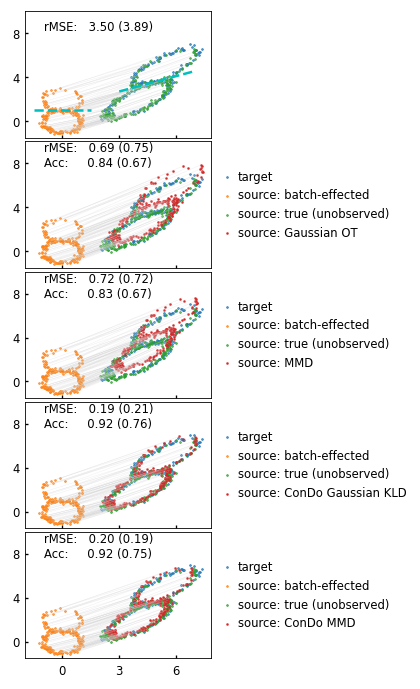

In [3]:
mmd_size = 20

rMSEs = defaultdict(list)
rMSEs_test = defaultdict(list)
udAccs = defaultdict(list)
udAccs_test = defaultdict(list)

rng = np.random.RandomState(0)

fig, axes = plt.subplots(
    nrows=5, ncols=1, sharex="all", sharey="all", squeeze=False,
    gridspec_kw={"hspace": 0.03, "wspace": 0.03},
    figsize=(2, 7), dpi=120);
msize = 0.25
basic_leg = ['target', 'source: batch-effected', 'source: true (unobserved)']
fsizemse = 7
n_lines = 100

n = 200
d = 2
sigma = .1
levery = n // n_lines
n_up_s = n // 4
n_down_s = n - n_up_s
n_up_t = n // 2
n_down_t = n // 2
ys = np.array(
    [['up']*n_up_s + ['down']*n_down_s]).reshape((n, 1))
yt = np.array(
    [['up']*n_up_t + ['down']*n_down_t]).reshape((n, 1))

# source samples
angles = rng.rand(n, 1) * 2 * np.pi
XS = (
    np.concatenate([np.cos(angles), np.sin(angles)], axis=1)
    + sigma * rng.randn(n, 2)
)
XS[:n_up_s, 1] += 2
angles_test = rng.rand(n, 1) * 2 * np.pi
XS_test = (
    np.concatenate([np.cos(angles_test), np.sin(angles_test)], axis=1)
    + sigma * rng.randn(n, 2)
)
XS_test[:n_up_t, 1] += 2

# target samples
anglet = rng.rand(n, 1) * 2 * np.pi
XT = (
    np.concatenate([np.sin(anglet), np.cos(anglet)], axis=1)
    + sigma * rng.randn(n, 2)
)
XT[:n_up_t, 1] += 2

# nonconfounding variable
A_true = np.array([[1.5, .7], [.7, 1.5]])
b_true = np.array([[4, 2]])
XT = XT.dot(A_true) + b_true
XS_true = XS.dot(A_true) + b_true
XS_test_true = XS_test.dot(A_true) + b_true

# Before correction
method = "Before Correction"
mix = 0
rMSE = np.sqrt(np.mean((XS - XS_true) ** 2));
rMSEs[method].append(rMSE)
rMSE_test = np.sqrt(np.mean((XS_test - XS_test_true) ** 2));
rMSEs_test[method].append(rMSE_test)
avgrMSE = np.mean(rMSEs[method])
avgrMSE_test = np.mean(rMSEs_test[method])
rmse_str = f"rMSE:   {avgrMSE:.2f} ({avgrMSE_test:.2f})"
axes[mix, 0].tick_params(axis="both", which="both", direction="in")    
axes[mix, 0].scatter(XT[:,0], XT[:,1], s=msize)
axes[mix, 0].scatter(XS[:,0], XS[:,1], s=msize)
axes[mix, 0].scatter(XS_true[:,0], XS_true[:,1], marker='o', s=msize);
axes[mix, 0].plot(
    np.vstack([XS[::levery, [0]].T, XS_true[::levery, [0]].T]),
    np.vstack([XS[::levery, [1]].T, XS_true[::levery, [1]].T]),
    alpha=0.5, linewidth=0.2, color="lightgray");
axes[mix, 0].plot([-1.5, 1.5], [1, 1], '--c');
ud_x1 = 3
ud_x2 = 7
axes[mix, 0].plot(
    [ud_x1, ud_x2],
    [
        A_true[0, 1]/A_true[0, 0]*ud_x1
        +(A_true[1,1]+b_true[0,1]-A_true[0,1]/A_true[0,0]*(A_true[1,0]+b_true[0,0])),
        A_true[0, 1]/A_true[0, 0]*ud_x2
        +(A_true[1,1]+b_true[0,1]-A_true[0,1]/A_true[0,0]*(A_true[1,0]+b_true[0,0])),
    ], '--c');
axes[mix, 0].text(
    0.1, 0.85, 
    f"{rmse_str}",
    size=fsizemse, transform = axes[mix, 0].transAxes);
axes[mix, 0].set_ylim(-1.5, 10);

# Oracle - not displayed
method = "Oracle"
XSoracle = XS @ A_true + b_true
XSoracle_back = (XSoracle - b_true) @ np.linalg.inv(A_true)
XSoracle_pred_ud = np.where(XSoracle_back[:,[1]] > 1.5, "up", "down")
XSoracle_test = XS_test @ A_true + b_true
XSoracle_test_back = (XSoracle_test - b_true) @ np.linalg.inv(A_true)
XSoracle_test_pred_ud = np.where(XSoracle_test_back[:,[1]] > 1.5, "up", "down")
# rmse
rMSE = np.sqrt(np.mean((XSoracle - XS_true) ** 2));
rMSEs[method].append(rMSE)
rMSE_test = np.sqrt(np.mean((XSoracle_test - XS_test_true) ** 2));
rMSEs_test[method].append(rMSE_test)
avgrMSE = np.mean(rMSEs[method])
avgrMSE_test = np.mean(rMSEs_test[method])
rmse_str = f"rMSE:   {avgrMSE:.2f} ({avgrMSE_test:.2f})"
# acc
ud_acc = np.mean(XSoracle_pred_ud == ys)
ud_test_acc = np.mean(XSoracle_test_pred_ud == ys)
udAccs[method].append(ud_acc)      
udAccs_test[method].append(ud_test_acc)
avg_udAccs = np.mean(udAccs[method])
avg_udAccs_test = np.mean(udAccs_test[method])
ud_str = f"U-vs-D: {avg_udAccs:.2f} ({avg_udAccs_test:.2f})"

method = "Gaussian OT"
mix = 1
lter = condo.AdapterGaussianOT(
    transform_type="affine",
)
lter.fit(Xs=XS, Xt=XT)
XSotda = lter.transform(Xs=XS)
XSotda_back = (XSotda - b_true) @ np.linalg.inv(A_true)
XSotda_pred_ud = np.where(XSotda_back[:,[1]] > 1.5, "up", "down")
XSotda_test = lter.transform(Xs=XS_test)
XSotda_test_back = (XSotda_test - b_true) @ np.linalg.inv(A_true)
XSotda_test_pred_ud = np.where(XSotda_test_back[:,[1]] > 1.5, "up", "down")
# rmse
rMSE = np.sqrt(np.mean((XSotda - XS_true) ** 2));
rMSEs[method].append(rMSE)
rMSE_test = np.sqrt(np.mean((XSotda_test - XS_test_true) ** 2));
rMSEs_test[method].append(rMSE_test)
avgrMSE = np.mean(rMSEs[method])
avgrMSE_test = np.mean(rMSEs_test[method])
rmse_str = f"rMSE:   {avgrMSE:.2f} ({avgrMSE_test:.2f})"
# acc
ud_acc = np.mean(XSotda_pred_ud == ys)
ud_test_acc = np.mean(XSotda_test_pred_ud == ys)
udAccs[method].append(ud_acc)      
udAccs_test[method].append(ud_test_acc)
avg_udAccs = np.mean(udAccs[method])
avg_udAccs_test = np.mean(udAccs_test[method])
ud_str = f"Acc:     {avg_udAccs:.2f} ({avg_udAccs_test:.2f})"
# plot
axes[mix, 0].tick_params(axis="both", which="both", direction="in")    
axes[mix, 0].scatter(XT[:,0], XT[:,1], s=msize)
axes[mix, 0].scatter(XS[:,0], XS[:,1], s=msize)
axes[mix, 0].scatter(XS_true[:,0], XS_true[:,1], marker='o', s=msize)
axes[mix, 0].scatter(XSotda[:,0], XSotda[:,1], marker='x', s=msize)
axes[mix, 0].plot(
    np.vstack([XS[::levery, [0]].T, XSotda[::levery, [0]].T]),
    np.vstack([XS[::levery, [1]].T, XSotda[::levery, [1]].T]),
    alpha=0.5, linewidth=0.2, color="lightgray");
axes[mix, 0].text(
    0.1, 0.8, 
    f"{rmse_str}\n{ud_str}",
    size=fsizemse, transform = axes[mix, 0].transAxes);        
axes[mix, 0].legend(
    basic_leg + [f"source: {method}"],
    loc="center left", bbox_to_anchor=(1.05, 0.5),
    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);

method = "MMD"
mix = 2
cder = condo.AdapterMMD(
    transform_type="affine",
    n_epochs=100,
    learning_rate=1e-2,
    mmd_size=mmd_size,
    verbose=0,
)
cder.fit(XS, XT)
XSmmd = cder.transform(XS)
XSmmd_test = cder.transform(XS_test)
XSmmd_back = (XSmmd - b_true) @ np.linalg.inv(A_true)
XSmmd_pred_ud = np.where(XSmmd_back[:,[1]] > 1.5, "up", "down")
XSmmd_test_back = (XSmmd_test - b_true) @ np.linalg.inv(A_true)
XSmmd_test_pred_ud = np.where(XSmmd_test_back[:,[1]] > 1.5, "up", "down")
# rmse
rMSE = np.sqrt(np.mean((XSmmd - XS_true) ** 2));
rMSEs[method].append(rMSE)
rMSE_test = np.sqrt(np.mean((XSmmd_test - XS_test_true) ** 2));
rMSEs_test[method].append(rMSE_test)
avgrMSE = np.mean(rMSEs[method])
avgrMSE_test = np.mean(rMSEs_test[method])
rmse_str = f"rMSE:   {avgrMSE:.2f} ({avgrMSE_test:.2f})"
# acc
ud_acc = np.mean(XSmmd_pred_ud == ys)
ud_test_acc = np.mean(XSmmd_test_pred_ud == ys)
udAccs[method].append(ud_acc)      
udAccs_test[method].append(ud_test_acc)
avg_udAccs = np.mean(udAccs[method])
avg_udAccs_test = np.mean(udAccs_test[method])
ud_str = f"Acc:     {avg_udAccs:.2f} ({avg_udAccs_test:.2f})"
# plot
axes[mix, 0].tick_params(axis="both", which="both", direction="in")    
axes[mix, 0].scatter(XT[:,0], XT[:,1], s=msize)
axes[mix, 0].scatter(XS[:,0], XS[:,1], s=msize)
axes[mix, 0].scatter(XS_true[:,0], XS_true[:,1], marker='o', s=msize)
axes[mix, 0].scatter(XSmmd[:,0], XSmmd[:,1], marker='x', s=msize)
axes[mix, 0].plot(
    np.vstack([XS[::levery, [0]].T, XSmmd[::levery, [0]].T]),
    np.vstack([XS[::levery, [1]].T, XSmmd[::levery, [1]].T]),
    alpha=0.5, linewidth=0.2, color="lightgray");
axes[mix, 0].text(
    0.1, 0.8, 
    f"{rmse_str}\n{ud_str}",
    size=fsizemse, transform = axes[mix, 0].transAxes);        

axes[mix, 0].legend(
    basic_leg + [f"source: {method}"],
    loc="center left", bbox_to_anchor=(1.05, 0.5),
    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);
    
method = "ConDo Gaussian KLD"
mix = 3
cder = condo.ConDoAdapterKLD(
    transform_type="affine",
    verbose=0,
)
cder.fit(XS, XT, ys, yt)
XSreverse = cder.transform(XS)
XSreverse_test = cder.transform(XS_test)
XSreverse_back = (XSreverse - b_true) @ np.linalg.inv(A_true)
XSreverse_pred_ud = np.where(XSreverse_back[:,[1]] > 1.5, "up", "down")
XSreverse_test_back = (XSreverse_test - b_true) @ np.linalg.inv(A_true)
XSreverse_test_pred_ud = np.where(XSreverse_test_back[:,[1]] > 1.5, "up", "down")
# rmse
rMSE = np.sqrt(np.mean((XSreverse - XS_true) ** 2));
rMSEs[method].append(rMSE)
rMSE_test = np.sqrt(np.mean((XSreverse_test - XS_test_true) ** 2));
rMSEs_test[method].append(rMSE_test)
avgrMSE = np.mean(rMSEs[method])
avgrMSE_test = np.mean(rMSEs_test[method])
rmse_str = f"rMSE:   {avgrMSE:.2f} ({avgrMSE_test:.2f})"
# acc
ud_acc = np.mean(XSreverse_pred_ud == ys)
ud_test_acc = np.mean(XSreverse_test_pred_ud == ys)
udAccs[method].append(ud_acc)      
udAccs_test[method].append(ud_test_acc)
avg_udAccs = np.mean(udAccs[method])
avg_udAccs_test = np.mean(udAccs_test[method])
ud_str = f"Acc:     {avg_udAccs:.2f} ({avg_udAccs_test:.2f})"
# plot
axes[mix, 0].tick_params(axis="both", which="both", direction="in")    
axes[mix, 0].scatter(XT[:,0], XT[:,1], s=msize)
axes[mix, 0].scatter(XS[:,0], XS[:,1], s=msize)
axes[mix, 0].scatter(XS_true[:,0], XS_true[:,1], marker='o', s=msize)
axes[mix, 0].scatter(XSreverse[:,0], XSreverse[:,1], marker='x', s=msize)
axes[mix, 0].plot(
    np.vstack([XS[::levery, [0]].T, XSreverse[::levery, [0]].T]),
    np.vstack([XS[::levery, [1]].T, XSreverse[::levery, [1]].T]),
    alpha=0.5, linewidth=0.2, color="lightgray");
axes[mix, 0].text(
    0.1, 0.8, 
    f"{rmse_str}\n{ud_str}",
    size=fsizemse, transform = axes[mix, 0].transAxes);        
axes[mix, 0].legend(
    basic_leg + [f"source: {method}"],
    loc="center left", bbox_to_anchor=(1.05, 0.5),
    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);

method = "ConDo MMD"
mix = 4
cder = condo.ConDoAdapterMMD(
    transform_type="affine",
    n_epochs=100,
    learning_rate=1e-2,
    mmd_size=mmd_size,
    verbose=0,
)
cder.fit(XS, XT, ys, yt)
XSmmd = cder.transform(XS)
XSmmd_test = cder.transform(XS_test)
XSmmd_back = (XSmmd - b_true) @ np.linalg.inv(A_true)
XSmmd_pred_ud = np.where(XSmmd_back[:,[1]] > 1.5, "up", "down")
XSmmd_test_back = (XSmmd_test - b_true) @ np.linalg.inv(A_true)
XSmmd_test_pred_ud = np.where(XSmmd_test_back[:,[1]] > 1.5, "up", "down")
# rmse
rMSE = np.sqrt(np.mean((XSmmd - XS_true) ** 2));
rMSEs[method].append(rMSE)
rMSE_test = np.sqrt(np.mean((XSmmd_test - XS_test_true) ** 2));
rMSEs_test[method].append(rMSE_test)
avgrMSE = np.mean(rMSEs[method])
avgrMSE_test = np.mean(rMSEs_test[method])
rmse_str = f"rMSE:   {avgrMSE:.2f} ({avgrMSE_test:.2f})"
# acc
ud_acc = np.mean(XSmmd_pred_ud == ys)
ud_test_acc = np.mean(XSmmd_test_pred_ud == ys)
udAccs[method].append(ud_acc)      
udAccs_test[method].append(ud_test_acc)
avg_udAccs = np.mean(udAccs[method])
avg_udAccs_test = np.mean(udAccs_test[method])
ud_str = f"Acc:     {avg_udAccs:.2f} ({avg_udAccs_test:.2f})"
# plot
axes[mix, 0].tick_params(axis="both", which="both", direction="in")    
axes[mix, 0].scatter(XT[:,0], XT[:,1], s=msize)
axes[mix, 0].scatter(XS[:,0], XS[:,1], s=msize)
axes[mix, 0].scatter(XS_true[:,0], XS_true[:,1], marker='o', s=msize)
axes[mix, 0].scatter(XSmmd[:,0], XSmmd[:,1], marker='x', s=msize)
axes[mix, 0].plot(
    np.vstack([XS[::levery, [0]].T, XSmmd[::levery, [0]].T]),
    np.vstack([XS[::levery, [1]].T, XSmmd[::levery, [1]].T]),
    alpha=0.5, linewidth=0.2, color="lightgray");
axes[mix, 0].text(
    0.1, 0.8, 
    f"{rmse_str}\n{ud_str}",
    size=fsizemse, transform = axes[mix, 0].transAxes);
axes[mix, 0].set_yticks([0, 4, 8]);
axes[mix, 0].set_xticks([0, 3, 6]);
axes[mix, 0].legend(
    basic_leg + [f"source: {method}"],
    loc="center left", bbox_to_anchor=(1.05, 0.5),
    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);
